In [1]:
import preprocessing as prep
import deceleration as dc
import comert_features as cf
import os
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [6]:
def get_available_records(db_path, start=1000, end=2050):
    """
    Automatically retrieve available record names within the given range
    by attempting to load records using wfdb.rdrecord.
    """
    available_records = []
    
    for i in range(start, end + 1):
        record_name = str(i)
        try:
            wfdb.rdrecord(f"{db_path}/{record_name}")
            available_records.append(record_name)
        except:
            continue
    
    return sorted(available_records)

def process_all_signals(db_path, pH_threshold=7.1, minLength=None, maxLength=None, tolerance = 1):
    record_names = get_available_records(db_path)
    results = []
    signal_lengths = []

    min_length = float('inf')  # To determine the minimum length for trimming

    # First pass: determine signal lengths
    for record_name in record_names:
        try:
            fhr, uc, fs, metadata_df = prep.preprocess_ctg_pipeline(
                record_name, db_path, tolerance=tolerance, interpolation_method='linear', plot=False
            )
            length_sec = len(fhr) / fs
            signal_lengths.append(length_sec)

            if len(fhr) < min_length:
                min_length = len(fhr)
        except:
            continue

    # Plot histogram of signal lengths (in minutes)
    plt.hist([l / 60 for l in signal_lengths], bins=30)
    if minLength is not None:
        plt.axvline(x=minLength, color='red', linestyle='--', label='Cut-off length')
        plt.legend()
    
    if maxLength is not None:
        plt.axvline(x=maxLength, color='green', linestyle='--', label='Cut-off length')
        plt.legend()
        
    plt.xlabel("Signal Length (minutes)")
    plt.ylabel("Number of Records")
    plt.title("Distribution of CTG Signal Lengths After Preprocessing")
    plt.grid(True)
    plt.show()

    # Second pass: process and trim signals
    for i, record_name in enumerate(record_names):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")

                fhr, uc, fs, metadata_df = prep.preprocess_ctg_pipeline(
                    record_name, db_path, tolerance=tolerance, interpolation_method='linear', plot=False
                )

                if fhr is None or uc is None:
                    print(f"Skipping record {record_name} as the signal shows no variability.")
                    continue

                if minLength is not None: 
                    # Discard too short signals
                    length = int(minLength * 60 * fs)
                    if len(fhr) < length:
                        print(f"Skipping record {record_name} as it is too short.")
                        continue

                if maxLength is not None: 
                    # Trim too long signals
                    length = int(maxLength * 60 * fs)
                    if len(fhr) > length:
                        fhr = fhr[:length]
                        uc = uc[:length]

                # pH extraction
                ph_value = None
                if not metadata_df.empty:
                    ph_row = metadata_df[metadata_df.iloc[:, 0] == 'pH']
                    if not ph_row.empty:
                        ph_value = float(ph_row.iloc[0, 1])
                if ph_value is None:
                    continue

                target = int(ph_value < pH_threshold)

                # Continue as usual...
                results_dict = dc.get_classified_decelerations(fhr, uc, fs, verbose=False)
                if results_dict is None:
                    continue

                (early_decs, late_decs, variable_decs,
                 decelerations, contractions, paired_events,
                 baseline_fhr) = results_dict

                fhr_array = np.array([fhr])
                linear_features = cf.get_linear_features(fhr_array, fs).flatten()
                morphological_features = cf.get_morphological_features(fhr_array).flatten()

                if not (np.isfinite(linear_features).all() and np.isfinite(morphological_features).all()):
                    continue
                    
                signal_duration_min = len(fhr) / fs / 60  # signal duration in minutes
                record_data = {
                    'record_name': record_name,
                    'early_decelerations': len(early_decs) / signal_duration_min,
                    'late_decelerations': len(late_decs) / signal_duration_min,
                    'variable_decelerations': len(variable_decs) / signal_duration_min,
                    'total_decelerations': len(decelerations) / signal_duration_min,
                    'contractions': len(contractions) / signal_duration_min,
                    'paired_events': len(paired_events) / signal_duration_min,
                    'baseline': baseline_fhr,
                    'std_FHR': linear_features[1],
                    'LTV': linear_features[2],
                    'delta': linear_features[3],
                    'STV': linear_features[4],
                    'II': linear_features[5],
                    'morph_baseline': morphological_features[0],
                    'morph_dcc': morphological_features[1],
                    'morph_acc': morphological_features[2],
                    'target': target
                }

                results.append(record_data)

        except (RuntimeError, Warning, ValueError, TypeError, KeyError) as e:
            print(f"Skipping record {record_name} due to processing error: {e}")

    df_results = pd.DataFrame(results)
    return df_results

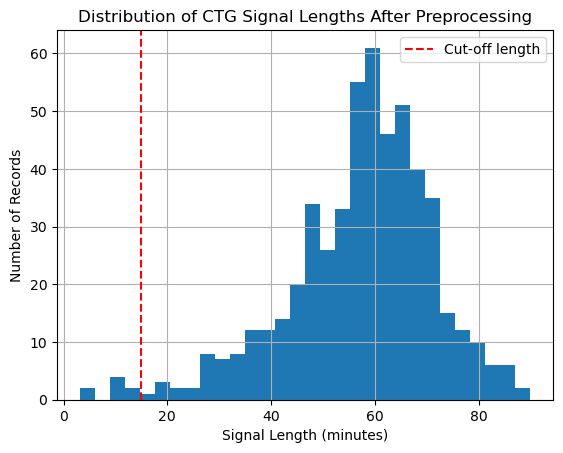

Skipping record 1104 as the signal shows no variability.
Skipping record 1119 as the signal shows no variability.
Skipping record 1130 as the signal shows no variability.
Skipping record 1149 as the signal shows no variability.
Skipping record 1155 as the signal shows no variability.
Skipping record 1186 as the signal shows no variability.
Skipping record 1188 as the signal shows no variability.
Skipping record 1258 as the signal shows no variability.
Skipping record 1327 as the signal shows no variability.
Skipping record 1451 as the signal shows no variability.
Skipping record 1477 as it is too short.
Skipping record 2003 as it is too short.


In [7]:
db_path = '../../ctu-chb-database'
results_df = process_all_signals(db_path, minLength=15, maxLength=None)

In [8]:
results_df.head()

,record_name,early_decelerations,late_decelerations,variable_decelerations,total_decelerations,contractions,paired_events,baseline,std_FHR,LTV,delta,STV,II,morph_baseline,morph_dcc,morph_acc,target
0,1001,0.032131,0.192784,0.096392,0.321307,0.722940,0.321307,136.896563,17.552659,16.509977,34.436864,3.253460,0.187226,138.477533,21.0,14.0,0
1,1002,0.069469,0.138937,0.027787,0.236193,0.694686,0.236193,149.519386,20.116324,17.251002,39.061614,3.340060,0.167565,152.877443,19.0,16.0,1
2,1003,0.050151,0.225682,0.000000,0.275833,0.451363,0.275833,123.414978,9.082117,15.700698,25.166667,2.623483,0.294247,124.950097,12.0,2.0,0
3,1004,0.045593,0.182371,0.030395,0.258359,0.592705,0.258359,137.675271,17.507201,16.558716,28.953846,2.688238,0.155043,140.367141,15.0,5.0,0
4,1005,0.109639,0.146185,0.054820,0.310644,0.566469,0.310644,120.472210,16.209344,15.488042,30.143519,2.901376,0.181551,121.875888,13.0,10.0,0


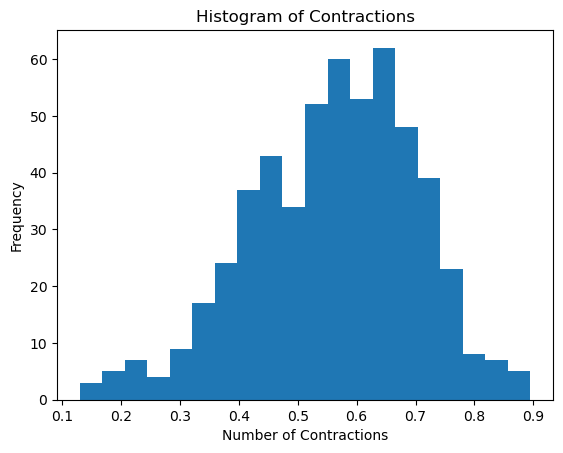

In [9]:
plt.hist(results_df['contractions'], bins=20)
plt.title('Histogram of Contractions')
plt.xlabel('Number of Contractions')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Define the file path
save_path = "processed_ctg_results.csv"

# Sort by 'record_name' before saving
results_df = results_df.sort_values(by="record_name")

# Save DataFrame as CSV
results_df.to_csv(save_path, index=False)

print(f"Results saved to {save_path}")


Results saved to processed_ctg_results.csv
